In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

## Dataset imports

### Asthma 1

In [2]:
from datetime import datetime

# Import asthma dataset
date_parser = lambda date : datetime.strptime(date, "%Y")
df = pd.read_csv(
    "Asthma Hospitalizations.csv",
    dtype={
        "Data":"float64"
    },
    parse_dates=["TimeFrame"],
    date_parser=date_parser
)
df["Year"] = df.TimeFrame.apply(lambda date: date.year)
print(df.dtypes)
df

Location              object
Age Group             object
TimeFrame     datetime64[ns]
DataFormat            object
Data                 float64
Fips                  object
Year                   int64
dtype: object


,Location,Age Group,TimeFrame,DataFormat,Data,Fips,Year
0,New York City,0 to 4 years,2000-01-01,Number,5727.0,3651000,2000
1,New York City,0 to 4 years,2001-01-01,Number,6024.0,3651000,2001
2,New York City,0 to 4 years,2003-01-01,Number,6591.0,3651000,2003
3,New York City,0 to 4 years,2004-01-01,Number,5823.0,3651000,2004
4,New York City,0 to 4 years,2005-01-01,Number,5027.0,3651000,2005
...,...,...,...,...,...,...,...
3258,South Beach - Tottenville,0 to 4 years,2005-01-01,Number,26.0,uhf504,2005
3259,South Beach - Tottenville,5 to 17 Years,2005-01-01,Number,22.0,uhf504,2005
3260,South Beach - Tottenville,0 to 4 years,2001-01-01,Number,29.0,uhf504,2001
3261,South Beach - Tottenville,0 to 4 years,2003-01-01,Number,36.0,uhf504,2003


In [3]:
# there is a problem with 0-4 years being in lower caps
df["Age Group"].unique()

array(['0 to 4 years', '5 to 17 Years', '0 to 17 Years'], dtype=object)

In [4]:
# we fix that
df["Age Group"] = df["Age Group"].str.replace("y","Y")

In [72]:
df

,Location,Age Group,TimeFrame,DataFormat,Data,Fips,Year
0,New York City,0 to 4 Years,2000-01-01,Number,5727.0,3651000,2000
1,New York City,0 to 4 Years,2001-01-01,Number,6024.0,3651000,2001
2,New York City,0 to 4 Years,2003-01-01,Number,6591.0,3651000,2003
3,New York City,0 to 4 Years,2004-01-01,Number,5823.0,3651000,2004
4,New York City,0 to 4 Years,2005-01-01,Number,5027.0,3651000,2005
...,...,...,...,...,...,...,...
3258,South Beach - Tottenville,0 to 4 Years,2005-01-01,Number,26.0,uhf504,2005
3259,South Beach - Tottenville,5 to 17 Years,2005-01-01,Number,22.0,uhf504,2005
3260,South Beach - Tottenville,0 to 4 Years,2001-01-01,Number,29.0,uhf504,2001
3261,South Beach - Tottenville,0 to 4 Years,2003-01-01,Number,36.0,uhf504,2003


In [5]:
# divide according to datatype and drop dataformat
df_num = df[df.DataFormat == "Number"]
df_rate = df[df.DataFormat == "Rate"]
df_num = df_num.rename(columns={"Data":"Numbers"})
df_num = df_num.drop(columns="DataFormat")
df_rate = df_rate.rename(columns={"Data":"Rate"})
df_rate = df_rate.drop(columns="DataFormat")

In [6]:
# df num has a age group that is just the sum of the other two
print(df_num["Age Group"].unique())
print(df_rate["Age Group"].unique())

['0 to 4 Years' '5 to 17 Years' '0 to 17 Years']
['0 to 4 Years' '5 to 17 Years']


In [7]:
# we see that 0-17 is just the sum of the other age groups
df_num[(df_num.Location == "New York City") & (df_num.TimeFrame== 2005)]

,Location,Age Group,TimeFrame,Numbers,Fips,Year


In [8]:
# we remove that
df_num = df_num[df_num["Age Group"] != "0 to 17 Years"]
df_num["Age Group"].unique()

array(['0 to 4 Years', '5 to 17 Years'], dtype=object)

In [9]:
# for some reason, there is a single datapoint less in rate than in numbers. We ignore this one datapoint
df_merged = pd.merge(df_num, df_rate, on = ["Location", "Age Group", "TimeFrame", "Fips", "Year"], how = "outer")
print(df_merged.shape)
df_merged[df_merged.Rate.isna()]

(1344, 7)


,Location,Age Group,TimeFrame,Numbers,Fips,Year,Rate
64,Bronx,0 to 4 Years,2006-01-01,1766.0,36005,2006,NaN


In [10]:
# merge datasets and rename
df_merged = pd.merge(df_num, df_rate, on = ["Location", "Age Group", "TimeFrame", "Fips", "Year"], how = "inner")
df_hosp = df_merged

In [11]:
# split timeframe into day month and year
df_hosp["Month"] = df_hosp.TimeFrame.apply(lambda date : date.month)
df_hosp["Day"] = df_hosp.TimeFrame.apply(lambda date : date.day)

# rename columns with spaces
df_hosp.rename(
    columns = {"Age Group" : "AgeGroup"}
)

,Location,AgeGroup,TimeFrame,Numbers,Fips,Year,Rate,Month,Day
0,New York City,0 to 4 Years,2000-01-01,5727.0,3651000,2000,106.2,1,1
1,New York City,0 to 4 Years,2001-01-01,6024.0,3651000,2001,112.5,1,1
2,New York City,0 to 4 Years,2003-01-01,6591.0,3651000,2003,124.1,1,1
3,New York City,0 to 4 Years,2004-01-01,5823.0,3651000,2004,109.5,1,1
4,New York City,0 to 4 Years,2005-01-01,5027.0,3651000,2005,95.1,1,1
...,...,...,...,...,...,...,...,...,...
1338,South Beach - Tottenville,0 to 4 Years,2005-01-01,26.0,uhf504,2005,24.3,1,1
1339,South Beach - Tottenville,5 to 17 Years,2005-01-01,22.0,uhf504,2005,6.7,1,1
1340,South Beach - Tottenville,0 to 4 Years,2001-01-01,29.0,uhf504,2001,25.7,1,1
1341,South Beach - Tottenville,0 to 4 Years,2003-01-01,36.0,uhf504,2003,32.7,1,1


### Air quality

In [12]:
# import air quality dataset
date_parser = lambda x: datetime.strptime(x, '%m/%d/%Y') # specify the date
df_air = pd.read_csv(
    "Air_Quality.csv",
    dtype={
        "Unique ID":"int64",
        "Indicator ID":"int64",
        "Geo Join ID":"int64",
        "Data Value":"float64",
    },
    parse_dates=["Start_Date"],
    date_parser=date_parser
)
df_air = df_air.drop(columns=["Message"])
print(df_air.dtypes)

Unique ID                  int64
Indicator ID               int64
Name                      object
Measure                   object
Measure Info              object
Geo Type Name             object
Geo Join ID                int64
Geo Place Name            object
Time Period               object
Start_Date        datetime64[ns]
Data Value               float64
dtype: object


In [13]:
# split date into day, month and year
df_air["Year"] = df_air.Start_Date.apply(lambda date: date.year)
df_air["Month"] = df_air.Start_Date.apply(lambda date: date.month)
df_air["Day"] = df_air.Start_Date.apply(lambda date: date.day)

# rename columns with spaces
df_air = df_air.rename(
    columns = {
        "Unique ID" : "UniqueID",
        "Indicator ID" : "IndicatorID",
        "Measure Info" : "MeasureInfo",
        "Geo Type Name" : "GeoTypeName",
        "Geo Join ID" : "GeoJoinID",
        "Geo Place Name" : "GeoPlaceName",
        "Time Period" : "TimePeriod",
        "Start_Date" : "StartDate",
        "Data Value" : "Value",
    }
)

df_air

,UniqueID,IndicatorID,Name,Measure,MeasureInfo,GeoTypeName,GeoJoinID,GeoPlaceName,TimePeriod,StartDate,Value,Year,Month,Day
0,130355,639,PM2.5-Attributable Deaths,Estimated Annual Rate - Adults 30 Yrs and Older,"per 100,000 adults",UHF42,101,Kingsbridge - Riverdale,2005-2007,2005-01-01,117.70,2005,1,1
1,130356,639,PM2.5-Attributable Deaths,Estimated Annual Rate - Adults 30 Yrs and Older,"per 100,000 adults",UHF42,102,Northeast Bronx,2005-2007,2005-01-01,77.30,2005,1,1
2,130357,639,PM2.5-Attributable Deaths,Estimated Annual Rate - Adults 30 Yrs and Older,"per 100,000 adults",UHF42,103,Fordham - Bronx Pk,2005-2007,2005-01-01,67.30,2005,1,1
3,130358,639,PM2.5-Attributable Deaths,Estimated Annual Rate - Adults 30 Yrs and Older,"per 100,000 adults",UHF42,104,Pelham - Throgs Neck,2005-2007,2005-01-01,73.60,2005,1,1
4,130359,639,PM2.5-Attributable Deaths,Estimated Annual Rate - Adults 30 Yrs and Older,"per 100,000 adults",UHF42,105,Crotona -Tremont,2005-2007,2005-01-01,65.80,2005,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16117,671118,386,Ozone (O3),Mean,ppb,CD,306,Park Slope and Carroll Gardens (CD6),Summer 2020,2020-06-01,28.70,2020,6,1
16118,671119,386,Ozone (O3),Mean,ppb,CD,305,East New York and Starrett City (CD5),Summer 2020,2020-06-01,29.56,2020,6,1
16119,671120,386,Ozone (O3),Mean,ppb,CD,304,Bushwick (CD4),Summer 2020,2020-06-01,29.65,2020,6,1
16120,671121,386,Ozone (O3),Mean,ppb,CD,303,Bedford Stuyvesant (CD3),Summer 2020,2020-06-01,29.28,2020,6,1


### Asthma 2

In [14]:
# handmade column names to get around multi-indexing
cols = ["Location"]
for year in range(2005, 2017):
    for cat in ("0-4y","5-17y","0-17y"):
        col = f"{year}_{cat}"
        cols.append(col)
print(cols)

['Location', '2005_0-4y', '2005_5-17y', '2005_0-17y', '2006_0-4y', '2006_5-17y', '2006_0-17y', '2007_0-4y', '2007_5-17y', '2007_0-17y', '2008_0-4y', '2008_5-17y', '2008_0-17y', '2009_0-4y', '2009_5-17y', '2009_0-17y', '2010_0-4y', '2010_5-17y', '2010_0-17y', '2011_0-4y', '2011_5-17y', '2011_0-17y', '2012_0-4y', '2012_5-17y', '2012_0-17y', '2013_0-4y', '2013_5-17y', '2013_0-17y', '2014_0-4y', '2014_5-17y', '2014_0-17y', '2015_0-4y', '2015_5-17y', '2015_0-17y', '2016_0-4y', '2016_5-17y', '2016_0-17y']


In [15]:
# import dataset
dtypes = {col:("str" if i==0 else "int") for i,col in enumerate(cols)}
df_hosp2 = pd.read_csv("Asthma_total_data2.csv", sep=";", names=cols).iloc[2:,:]
df_hosp2 = df_hosp2.astype(dtypes)
df_hosp2.head()

,Location,2005_0-4y,2005_5-17y,2005_0-17y,2006_0-4y,2006_5-17y,2006_0-17y,2007_0-4y,2007_5-17y,2007_0-17y,...,2013_0-17y,2014_0-4y,2014_5-17y,2014_0-17y,2015_0-4y,2015_5-17y,2015_0-17y,2016_0-4y,2016_5-17y,2016_0-17y
0.0,New York City,5027,4656,9683,5164,4525,9689,4665,4194,8859,...,7738,3922,4106,8028,3514,3547,7061,3380,3373,6753
1.0,Bronx,1791,1594,3385,1766,1542,3308,1691,1476,3167,...,3166,1569,1691,3260,1407,1489,2896,1317,1340,2657
2.0,Brooklyn,1481,1414,2895,158,1424,3004,1309,1200,2509,...,2233,1147,1155,2302,1023,994,2017,977,990,1967
3.0,Manhattan,597,698,1295,654,605,1259,526,598,1124,...,901,460,482,942,400,421,821,416,440,856
4.0,Queens,1026,831,1857,1048,823,1871,1033,814,1847,...,1239,654,663,1317,602,540,1142,559,506,1650


In [16]:
# use regex to get the UHF code from location
def get_uhf_hosp2(location):
    re_s = re.search("\(.*?\)", location)
    if re_s: return location[re_s.span()[0]+1:-1]
    else: return 0

In [17]:
# melt dataset such that each row is a sample (like the other datasets)

df_hosp2_melted = df_hosp2.melt(id_vars="Location", value_vars=list(df_hosp2.columns[1:]), var_name="Year and age", value_name="n")
df_hosp2_melted["Year"] = df_hosp2_melted["Year and age"].str[0:4].astype("int")
df_hosp2_melted["AgeGroup"] = df_hosp2_melted["Year and age"].str[5:].astype("str")
df_hosp2_melted["Uhf"] = df_hosp2_melted.Location.apply(get_uhf_hosp2)
df_hosp2_melted["Uhf"] = df_hosp2_melted["Uhf"].astype("int")
print(df_hosp2_melted.dtypes)

df_hosp2_melted

Location        object
Year and age    object
n                int64
Year             int64
AgeGroup        object
Uhf              int64
dtype: object


,Location,Year and age,n,Year,AgeGroup,Uhf
0,New York City,2005_0-4y,5027,2005,0-4y,0
1,Bronx,2005_0-4y,1791,2005,0-4y,0
2,Brooklyn,2005_0-4y,1481,2005,0-4y,0
3,Manhattan,2005_0-4y,597,2005,0-4y,0
4,Queens,2005_0-4y,1026,2005,0-4y,0
...,...,...,...,...,...,...
1723,Upper West Side(304),2016_0-17y,43,2016,0-17y,304
1724,Washington Heights - Inwood(301),2016_0-17y,210,2016,0-17y,301
1725,West Queens(402),2016_0-17y,199,2016,0-17y,402
1726,Williamsburg - Bushwick(211),2016_0-17y,240,2016,0-17y,211


## Misc plots and maps

In [18]:
# there seems to be more data with the per 100.000 adults metric
print(df_air[df_air.MeasureInfo == "ppb"].shape)
print(df_air[df_air.MeasureInfo != "ppb"].shape)

(7896, 14)
(8226, 14)


<AxesSubplot:xlabel='Month'>

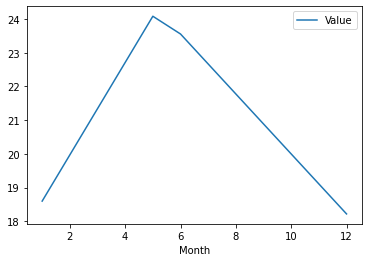

In [19]:
# check the monnthly change
df_air[df_air.MeasureInfo == "ppb"][["Value","Month"]].groupby("Month").mean().plot()

In [20]:
df_air[df_air.MeasureInfo == "ppb"].Month.unique() # only 4 datapoints so not so representative but it still changes a lot

array([12,  6,  1,  5])

<AxesSubplot:xlabel='Year'>

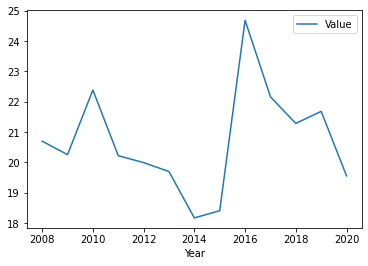

In [21]:
df_air[df_air.MeasureInfo == "ppb"][["Value","Year"]].groupby("Year").mean().plot()

In [66]:
df_rate

,Location,Age Group,TimeFrame,Rate,Fips,Year
40,New York City,0 to 4 Years,2016-01-01,61.1,3651000,2016
41,New York City,5 to 17 Years,2016-01-01,27.2,3651000,2016
42,New York City,0 to 4 Years,2015-01-01,62.6,3651000,2015
43,New York City,5 to 17 Years,2015-01-01,28.9,3651000,2015
44,New York City,5 to 17 Years,2014-01-01,33.5,3651000,2014
...,...,...,...,...,...,...
3218,South Beach - Tottenville,0 to 4 Years,2014-01-01,21.0,uhf504,2014
3219,South Beach - Tottenville,0 to 4 Years,2016-01-01,23.4,uhf504,2016
3220,South Beach - Tottenville,5 to 17 Years,2016-01-01,3.9,uhf504,2016
3223,South Beach - Tottenville,0 to 4 Years,2015-01-01,10.6,uhf504,2015


<AxesSubplot:xlabel='StartDate', ylabel='Value'>

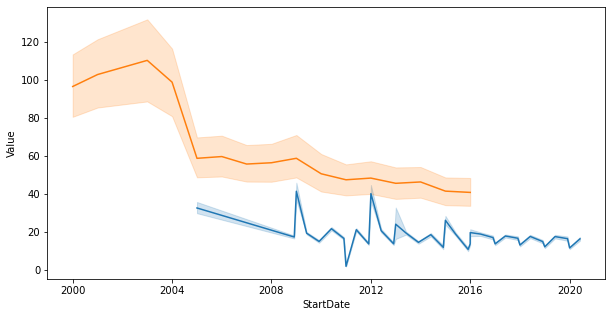

In [22]:
# compare asthma rate and polution values. Very simplified. A shame that we don't have data from before 2004. It looks quite interesting
plt.figure(figsize=(10,5))
sns.lineplot(data = df_air[["StartDate", "Value"]], x = "StartDate", y = "Value")
sns.lineplot(data = df_hosp[["TimeFrame","Rate"]], x = "TimeFrame", y = "Rate")

In [25]:
#Import Libraries for map plotting
import geopandas as gpd
import pandas as pd
import numpy as np
import folium
from folium.features import GeoJsonTooltip

#Read the geoJSON file using geopandas
geojson = gpd.read_file("georef-united-states-of-america-county.geojson")
#geojson = geojson[['coty_code','geometry']] #only select 'coty_code' (country fips) and 'geometry' columns

In [26]:
# The datasets use UHF42 shapefiles. We import those

uhf42shapes = gpd.read_file(
    "UHF_42_DOHMH_2009/UHF_42_DOHMH_2009.shp",
    dtypes = {"UHFCODE":"int"}
)
uhf42shapes["UHFCODE"] = uhf42shapes.UHFCODE.astype("int")
uhf42shapes.head()

,OBJECTID,UHFCODE,SHAPE_Leng,SHAPE_Area,UHF_NEIGH,BOROUGH,geometry
0,1,0,207587.595627,2.764099e+08,None,N/A,"MULTIPOLYGON (((1052698.331 161778.389, 105230..."
1,2,101,57699.154353,1.332914e+08,Kingsbridge - Riverdale,Bronx,"POLYGON ((1017992.893 269222.964, 1017812.000 ..."
2,3,102,88219.319109,1.813708e+08,Northeast Bronx,Bronx,"POLYGON ((1025012.990 270794.260, 1025061.481 ..."
3,4,103,59711.871991,1.407724e+08,Fordham - Bronx Park,Bronx,"POLYGON ((1023994.480 261065.967, 1023885.806 ..."
4,5,104,250903.372273,3.865737e+08,Pelham - Throgs Neck,Bronx,"MULTIPOLYGON (((1017075.039 237316.182, 101707..."


In [27]:
# check if it matches the dataset
for id in df_air[df_air.GeoTypeName == "UHF42"].GeoJoinID:
    if not id in list(uhf42shapes.UHFCODE): print(id) # print UHF42 ID if not a shapefile is not present

In [28]:
# they are all here. We remove unecesary columns
geojson_ny = uhf42shapes[["UHFCODE", "geometry"]]

# merge shapefiles into df air. not used but might be useful
df_air_geo = df_air.merge(geojson_ny, left_on = "GeoJoinID", right_on = "UHFCODE", how = "left")

In [29]:
# get the mean polution per neighbourhood
df_air_choro = df_air[df_air.MeasureInfo == "ppb"][["Value","GeoJoinID"]].groupby("GeoJoinID", as_index=0).mean()
df_air_choro

,GeoJoinID,Value
0,1,19.680399
1,2,19.950179
2,3,23.686786
3,4,19.425714
4,5,16.144643
...,...,...
67,309310,23.672321
68,404406,18.727143
69,501502,17.494821
70,503504,15.574464


In [30]:
import folium
from folium import plugins
from folium.plugins import HeatMap

lat, lon = 40.682030, -74.046082
map_ny = folium.Map([lat, lon], zoom_start=11, tiles = "cartodbpositron")
map_ny.choropleth(
    geo_data=geojson_ny,
    name='Choropleth',
    data=df_air_choro,
    columns=['GeoJoinID','Value'],
    key_on="properties.UHFCODE",
    fill_color='YlGnBu',
    fill_opacity=1,
    line_opacity=0.2,
    legend_name='Mean air polution value in ppb',
    smooth_factor=0
)
map_ny

/Users/lluiscolomercoll/opt/anaconda3/lib/python3.8/site-packages/folium/folium.py:409: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


In [31]:
df_hosp

,Location,Age Group,TimeFrame,Numbers,Fips,Year,Rate,Month,Day
0,New York City,0 to 4 Years,2000-01-01,5727.0,3651000,2000,106.2,1,1
1,New York City,0 to 4 Years,2001-01-01,6024.0,3651000,2001,112.5,1,1
2,New York City,0 to 4 Years,2003-01-01,6591.0,3651000,2003,124.1,1,1
3,New York City,0 to 4 Years,2004-01-01,5823.0,3651000,2004,109.5,1,1
4,New York City,0 to 4 Years,2005-01-01,5027.0,3651000,2005,95.1,1,1
...,...,...,...,...,...,...,...,...,...
1338,South Beach - Tottenville,0 to 4 Years,2005-01-01,26.0,uhf504,2005,24.3,1,1
1339,South Beach - Tottenville,5 to 17 Years,2005-01-01,22.0,uhf504,2005,6.7,1,1
1340,South Beach - Tottenville,0 to 4 Years,2001-01-01,29.0,uhf504,2001,25.7,1,1
1341,South Beach - Tottenville,0 to 4 Years,2003-01-01,36.0,uhf504,2003,32.7,1,1


In [32]:
def remove_paranthesis(s):
    if re.search("\(.*?\)",s):
        i1, i2 = re.search("\(.*?\)",s).span()
        return s[:i1]
    return s

In [33]:
air_names = {remove_paranthesis(name) for name in df_air.GeoPlaceName.unique()}

In [34]:
hosp_names = {remove_paranthesis(name) for name in df_hosp.Location.unique()}

In [35]:
air_names.symmetric_difference(hosp_names)
hosp_names.difference(air_names)

{'Crotona - Tremont',
 'Downtown  - Heights - Slope',
 'Fordham - Bronx Park',
 'Gramercy Park -  Murray Hill',
 'Greenwich Village - Soho',
 'Port  Richmond',
 'Rockaway',
 'Washington Heights - Inwood'}

In [36]:
df_plots = df_air[["Value", "Year", "GeoPlaceName"]].merge(df_hosp[["Rate", "Year", "Location"]], left_on = ["GeoPlaceName","Year"], right_on = ["Location","Year"], how="left")

In [37]:
df_plots = df_plots.dropna()
df_plots = df_plots.drop(columns=("GeoPlaceName"))

In [38]:
df_plots

,Value,Year,Rate,Location
0,117.7,2005,56.4,Kingsbridge - Riverdale
1,117.7,2005,18.9,Kingsbridge - Riverdale
2,77.3,2005,110.4,Northeast Bronx
3,77.3,2005,42.7,Northeast Bronx
5,73.6,2005,139.0,Pelham - Throgs Neck
...,...,...,...,...
20531,7.7,2015,5.4,Willowbrook
20532,7.7,2015,10.6,South Beach - Tottenville
20533,7.7,2015,8.7,South Beach - Tottenville
20534,4.8,2015,62.6,New York City


In [39]:
cities20 = df_plots.groupby("Location", as_index=0).count().sort_values("Year", ascending=False).Location[:5]
idx = cities20.index
cities20

20    Long Island City - Astoria
12                 East New York
25          Pelham - Throgs Neck
24               Northeast Bronx
29              Southeast Queens
Name: Location, dtype: object

In [40]:
d = df_plots.groupby(["Location", "Year"], as_index=0).mean()

In [41]:
d

,Location,Year,Value,Rate
0,Bayside - Little Neck,2005,15.626667,18.30
1,Bayside - Little Neck,2008,14.192000,34.35
2,Bayside - Little Neck,2009,13.997222,29.25
3,Bayside - Little Neck,2010,16.413750,17.55
4,Bayside - Little Neck,2011,11.941000,11.70
...,...,...,...,...
395,Willowbrook,2012,17.382548,17.95
396,Willowbrook,2013,10.122727,13.10
397,Willowbrook,2014,13.020000,14.75
398,Willowbrook,2015,13.074348,15.45


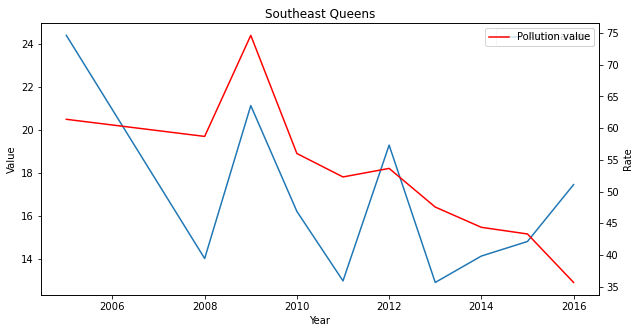

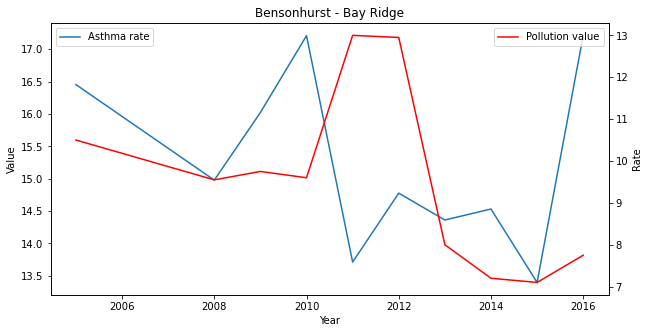

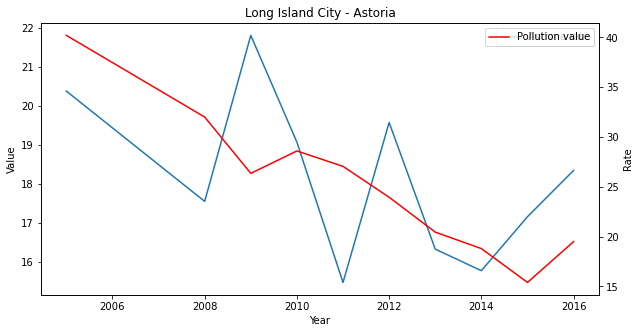

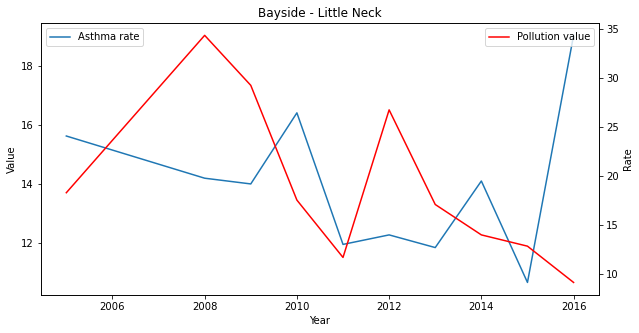

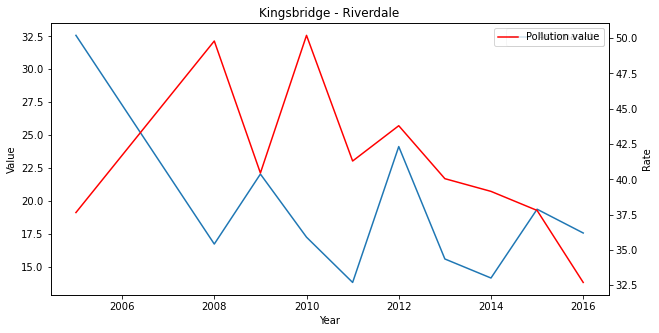

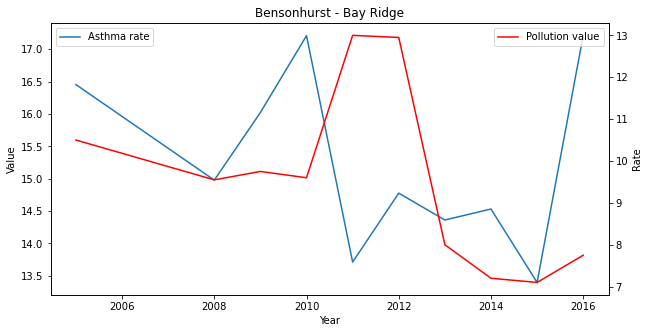

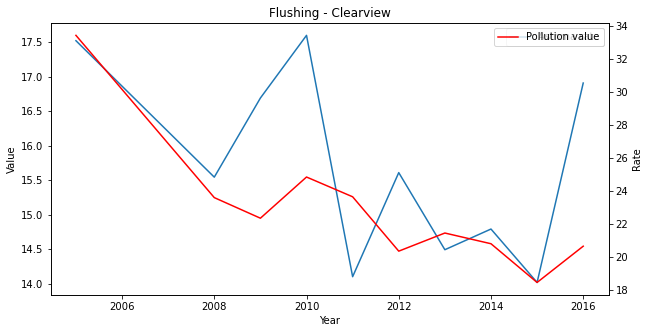

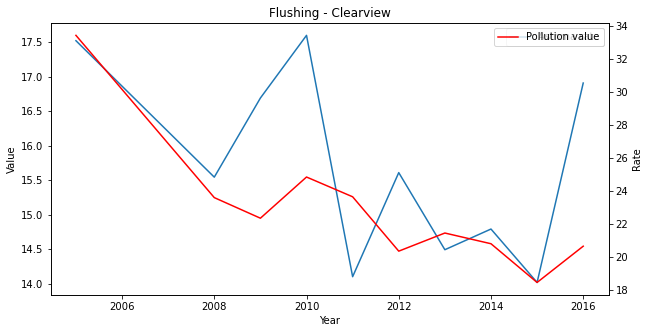

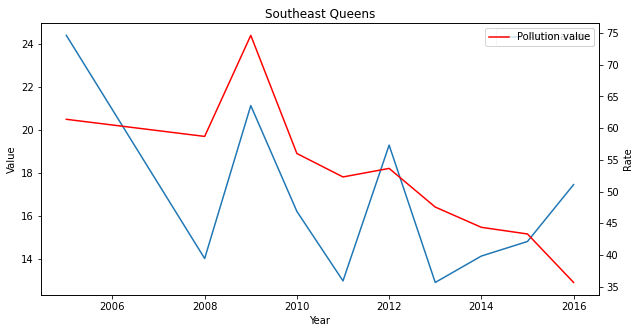

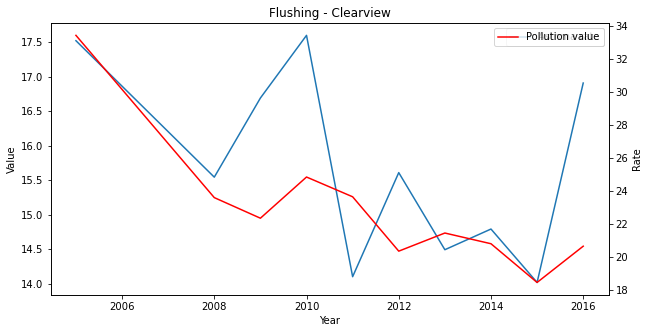

In [68]:
rand_cities = [d.Location[np.random.randint(400)] for _ in range(10)]
for city in rand_cities:
    plt.figure(figsize = (10,5))
    sns.lineplot(data = d[d.Location == city], x = "Year", y = "Value").set_title(city)
    plt.twinx()
    sns.lineplot(data = d[d.Location == city], x = "Year", y = "Rate", color = "r")
    plt.legend()

<AxesSubplot:xlabel='Rate', ylabel='Value'>

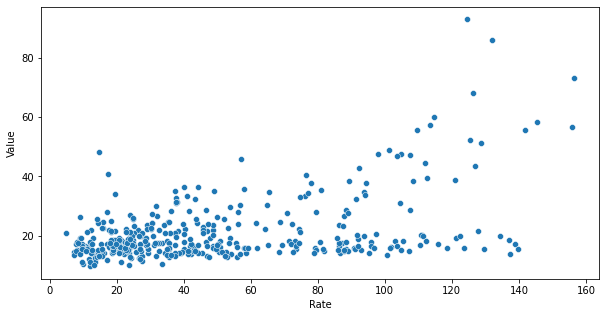

In [43]:
plt.figure(figsize = (10,5))
sns.scatterplot(x = d["Rate"], y= d["Value"])

In [44]:
d[["Value", "Rate"]].corr()

,Value,Rate
Value,1.000000,0.480521
Rate,0.480521,1.000000


In [69]:
df_hosp2_melted

,Location,Year and age,n,Year,AgeGroup,Uhf
6,Bayside - Little Neck(404),2005_0-4y,10,2005,0-4y,404
7,Bedford Stuyvesant - Crown Heights(203),2005_0-4y,379,2005,0-4y,203
8,Bensonhurst - Bay Ridge(209),2005_0-4y,20,2005,0-4y,209
9,Borough Park(206),2005_0-4y,42,2005,0-4y,206
10,Canarsie - Flatlands(208),2005_0-4y,106,2005,0-4y,208
...,...,...,...,...,...,...
1723,Upper West Side(304),2016_0-17y,43,2016,0-17y,304
1724,Washington Heights - Inwood(301),2016_0-17y,210,2016,0-17y,301
1725,West Queens(402),2016_0-17y,199,2016,0-17y,402
1726,Williamsburg - Bushwick(211),2016_0-17y,240,2016,0-17y,211


In [71]:
df_hosp2_melted_mean

,Uhf,n
0,0,1837.754630
1,101,42.444444
2,102,197.277778
3,103,390.277778
4,104,352.111111
5,105,374.166667
6,106,400.722222
7,107,297.888889
8,201,35.111111
9,202,93.555556


In [45]:
df_hosp2_melted_mean = df_hosp2_melted[["Uhf","n"]].groupby("Uhf", as_index=0).mean()
df_hosp2_melted = df_hosp2_melted[df_hosp2_melted.Uhf != 0]
df_hosp2_melted_mean.head()

,Uhf,n
0,0,1837.754630
1,101,42.444444
2,102,197.277778
3,103,390.277778
4,104,352.111111


In [46]:
import folium
from folium import plugins
from folium.plugins import HeatMap

lat, lon = 40.682030, -74.046082
map_ny = folium.Map([lat, lon], zoom_start=11, tiles = "cartodbpositron")
map_ny.choropleth(
    geo_data=geojson_ny,
    name='Choropleth',
    data=df_hosp2_melted_mean,
    columns=['Uhf','n'],
    key_on="properties.UHFCODE",
    fill_color='YlGnBu',
    fill_opacity=1,
    line_opacity=0.2,
    legend_name='n',
    smooth_factor=0
)
map_ny

/Users/lluiscolomercoll/opt/anaconda3/lib/python3.8/site-packages/folium/folium.py:409: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


## Timeseries choropleth of polution and asthma

In [52]:
df_hosp2_melted.head()

,Location,Year and age,n,Year,AgeGroup,Uhf
6,Bayside - Little Neck(404),2005_0-4y,10,2005,0-4y,404
7,Bedford Stuyvesant - Crown Heights(203),2005_0-4y,379,2005,0-4y,203
8,Bensonhurst - Bay Ridge(209),2005_0-4y,20,2005,0-4y,209
9,Borough Park(206),2005_0-4y,42,2005,0-4y,206
10,Canarsie - Flatlands(208),2005_0-4y,106,2005,0-4y,208


In [53]:
df_air.head()

,UniqueID,IndicatorID,Name,Measure,MeasureInfo,GeoTypeName,GeoJoinID,GeoPlaceName,TimePeriod,StartDate,Value,Year,Month,Day
0,130355,639,PM2.5-Attributable Deaths,Estimated Annual Rate - Adults 30 Yrs and Older,"per 100,000 adults",UHF42,101,Kingsbridge - Riverdale,2005-2007,2005-01-01,117.7,2005,1,1
1,130356,639,PM2.5-Attributable Deaths,Estimated Annual Rate - Adults 30 Yrs and Older,"per 100,000 adults",UHF42,102,Northeast Bronx,2005-2007,2005-01-01,77.3,2005,1,1
2,130357,639,PM2.5-Attributable Deaths,Estimated Annual Rate - Adults 30 Yrs and Older,"per 100,000 adults",UHF42,103,Fordham - Bronx Pk,2005-2007,2005-01-01,67.3,2005,1,1
3,130358,639,PM2.5-Attributable Deaths,Estimated Annual Rate - Adults 30 Yrs and Older,"per 100,000 adults",UHF42,104,Pelham - Throgs Neck,2005-2007,2005-01-01,73.6,2005,1,1
4,130359,639,PM2.5-Attributable Deaths,Estimated Annual Rate - Adults 30 Yrs and Older,"per 100,000 adults",UHF42,105,Crotona -Tremont,2005-2007,2005-01-01,65.8,2005,1,1


In [54]:
df_air.Name.unique()

array(['PM2.5-Attributable Deaths',
       'Boiler Emissions- Total SO2 Emissions',
       'Boiler Emissions- Total PM2.5 Emissions',
       'Boiler Emissions- Total NOx Emissions',
       'Air Toxics Concentrations- Average Benzene Concentrations',
       'Air Toxics Concentrations- Average Formaldehyde Concentrations',
       'PM2.5-Attributable Asthma Emergency Department Visits',
       'PM2.5-Attributable Respiratory Hospitalizations (Adults 20 Yrs and Older)',
       'PM2.5-Attributable Cardiovascular Hospitalizations (Adults 40 Yrs and Older)',
       'O3-Attributable Cardiac and Respiratory Deaths',
       'O3-Attributable Asthma Emergency Department Visits',
       'O3-Attributable Asthma Hospitalizations',
       'Traffic Density- Annual Vehicle Miles Traveled',
       'Traffic Density- Annual Vehicle Miles Traveled for Cars',
       'Traffic Density- Annual Vehicle Miles Traveled for Trucks',
       'Sulfur Dioxide (SO2)', 'Nitrogen Dioxide (NO2)',
       'Fine Particulate M

In [55]:
from folium.plugins import TimeSliderChoropleth

In [56]:
# create dataset consisting of the inner join of df_air and df_hosp2_melted, merged on UHF and YEAR
gb_hosp = df_hosp2_melted[df_hosp2_melted.AgeGroup == "0-17y"].groupby(["Uhf", "Year"], as_index=False).mean() # get hospitalization data grouped by year and neighbourhood
gb_air = df_air[df_air.Name == "Fine Particulate Matter (PM2.5)"][["Year","Value","GeoJoinID"]].groupby(["GeoJoinID", "Year"], as_index=False).mean()

In [57]:
df_hosp.Year.unique()

array([2000, 2001, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016])

In [58]:
df_air.Year.unique()

array([2005, 2013, 2009, 2008, 2010, 2011, 2012, 2015, 2014, 2016, 2017,
       2018, 2019, 2020])

In [59]:
gb_chorotime = gb_hosp.merge(gb_air, left_on=["Year","Uhf"], right_on=["Year", "GeoJoinID"], how = "inner")

In [60]:
# rename, change dtypes and remove duplicate columns
gb_chorotime = gb_chorotime.rename(
    columns={
        "n" : "Hosp_value",
        "Value" : "Air_value",
    }
)

gb_chorotime = gb_chorotime.astype({"Year":"int", "Uhf":"int"})

gb_chorotime = gb_chorotime.drop(columns="GeoJoinID")

gb_chorotime["Hosp_value"] = gb_chorotime.Hosp_value / max(gb_chorotime.Hosp_value) # map to values between 0 and 1
gb_chorotime["Air_value"] = gb_chorotime.Air_value / max(gb_chorotime.Air_value) # --//--
gb_chorotime

,Uhf,Year,Hosp_value,Air_value
0,101,2008,0.102453,0.864973
1,101,2009,0.088023,0.730143
2,101,2010,0.106782,0.819694
3,101,2011,0.093795,0.698063
4,101,2012,0.096681,0.696265
...,...,...,...,...
373,504,2012,0.054834,0.586287
374,504,2013,0.056277,0.623186
375,504,2014,0.057720,0.505583
376,504,2015,0.054834,0.476453


In [61]:
# create colormap for plotting polution
import branca.colormap as cm
colormap = cm.LinearColormap(vmin=0, vmax=1, colors=["lightgreen", "black"])
print(colormap(0.2))
colormap

#73bf73ff


In [62]:
# creating the style dict for the choropleth.
# it consists of a dict of dicts of dicts.
# styledict = {
#     shapefile_index : {
#         date_in_unix_time : {color:, opacity:},
#         date_in_unix_time : {color:, opacity:},
#         date_in_unix_time : {color:, opacity:}
#     }
#     shapefile_index : {
#         date_in_unix_time : {color:, opacity:},
#         date_in_unix_time : {color:, opacity:},
#         date_in_unix_time : {color:, opacity:}
#     }
# }

uhf_to_idx = {row.UHFCODE:str(idx) for idx, row in geojson_ny.iterrows()} # map uhf to index in geojson

style_dict = {}
for idx, uhf, year, hosp_value, air_value in gb_chorotime.itertuples():    
    year_epoch = str(datetime(year, 1, 1).timestamp()) # convert year to ms after epoch

    if uhf_to_idx[uhf] in style_dict: style_dict[uhf_to_idx[uhf]][year_epoch] = {"color":colormap(air_value), "opacity":hosp_value}
    else: style_dict[uhf_to_idx[uhf]] = {year_epoch: {"color":colormap(air_value),"opacity":hosp_value}}

In [63]:
uhf42shapes_converted = uhf42shapes.to_crs(epsg=4326) # convert to format compatible with timeslider choropleth

In [73]:
# plot

lat, lon = 40.682030, -74.046082
map_ny = folium.Map([lat, lon], zoom_start=11, tiles = "cartodbpositron")

# folium.Choropleth(
#     geo_data=geojson_ny,
#     name='Choropleth',
#     data=df_hosp2_melted_mean,
#     columns=['Uhf','n'],
#     key_on="properties.UHFCODE",
#     fill_color='YlGnBu',
#     fill_opacity=0.5,
#     line_opacity=0.2,
#     legend_name='n',
#     smooth_factor=0
# ).add_to(map_ny)

TimeSliderChoropleth(
    #geojson_ny.to_json(),
    uhf42shapes_converted.to_json(),
    style_dict
).add_to(map_ny)

map_ny

In [504]:
df_hosp.Year.unique()

array([2000, 2001, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016])

In [505]:
df_hosp2_melted.Year.unique()

array([2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016])

In [506]:
df_air.Year.unique()

array([2005, 2013, 2009, 2008, 2010, 2011, 2012, 2015, 2014, 2016, 2017,
       2018, 2019, 2020])